In [222]:
jupyterlab_url = "http://localhost:8888/lab?token=a30d0405c798fe316cc653a79790992b3222b98411dcf1a7"
default_result_path = None
close_on_fail = False
transition_timeout = 10000
default_delay = 200

In [223]:
import tempfile

work_dir = tempfile.mkdtemp()
if default_result_path is None:
    default_result_path = work_dir
work_dir

'/var/folders/m0/myy2ys0s3cl_73__2gw8fw140000gn/T/tmph43o09lc'

# Sidestickies E2E Test - File Browser Toggle on JupyterLab

- Test that the sidestickies toggle button works in the file browser
- Verify that notebook tag widgets appear on .ipynb files when toggled on

In [224]:
import re
import asyncio
import importlib

import scripts.playwright
importlib.reload(scripts.playwright)

from scripts.playwright import *

from scripts import sidestickies

await init_pw_context(close_on_fail=close_on_fail, last_path=default_result_path, delay=default_delay)

('20251102-070037',
 '/var/folders/m0/myy2ys0s3cl_73__2gw8fw140000gn/T/tmp0wtov2bq')

## Open JupyterLab and wait for it to load

Start epoch: 1762034437.875645 seconds


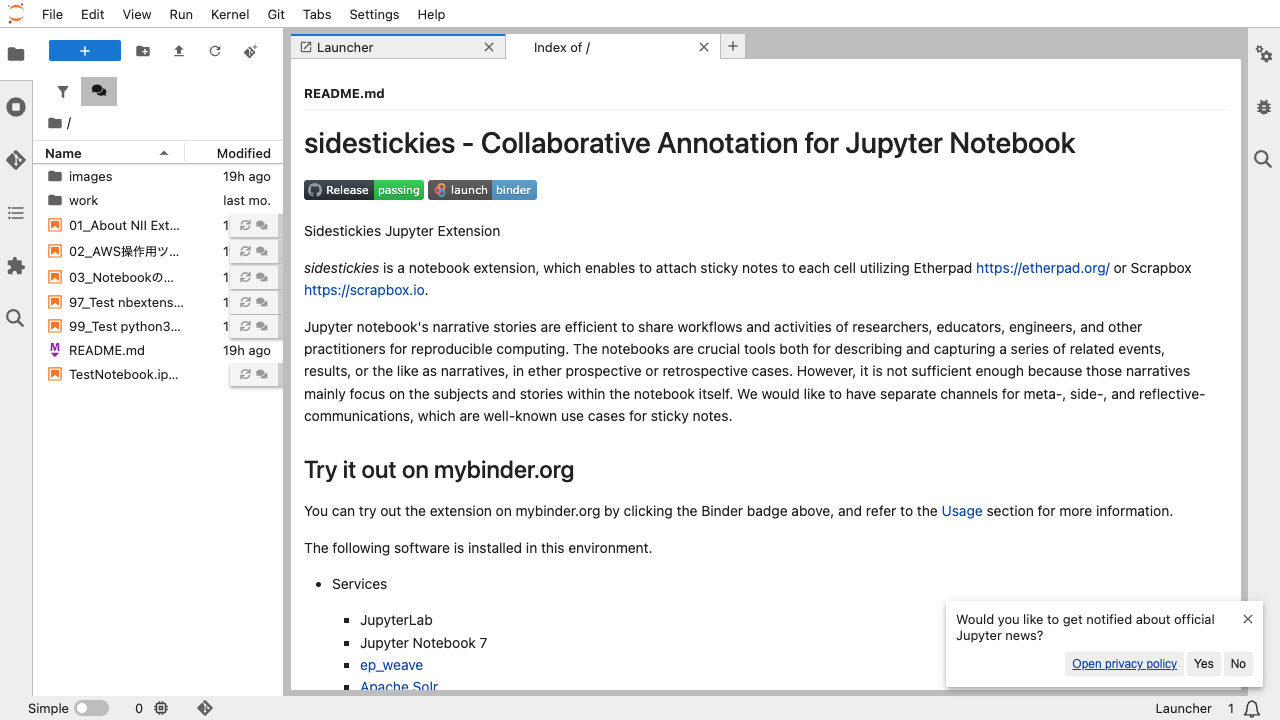

In [225]:
import scripts.sidestickies
importlib.reload(scripts.sidestickies)

lab_page = None

async def _step(page):
    await page.goto(jupyterlab_url)

    # Wait for JupyterLab to load
    await expect(page.locator('#jp-main-dock-panel')).to_be_visible(timeout=transition_timeout)

    # Wait for file browser to be visible
    await expect(page.locator('.jp-DirListing')).to_be_visible(timeout=transition_timeout)

    # Wait for the work directory to be visible
    await expect(sidestickies.get_file_browser_item_locator(page, 'work')).to_be_visible(timeout=transition_timeout)

    global lab_page
    lab_page = page

await run_pw(_step)

## Remove existing test notebook if it exists

Start epoch: 1762034441.8519292 seconds


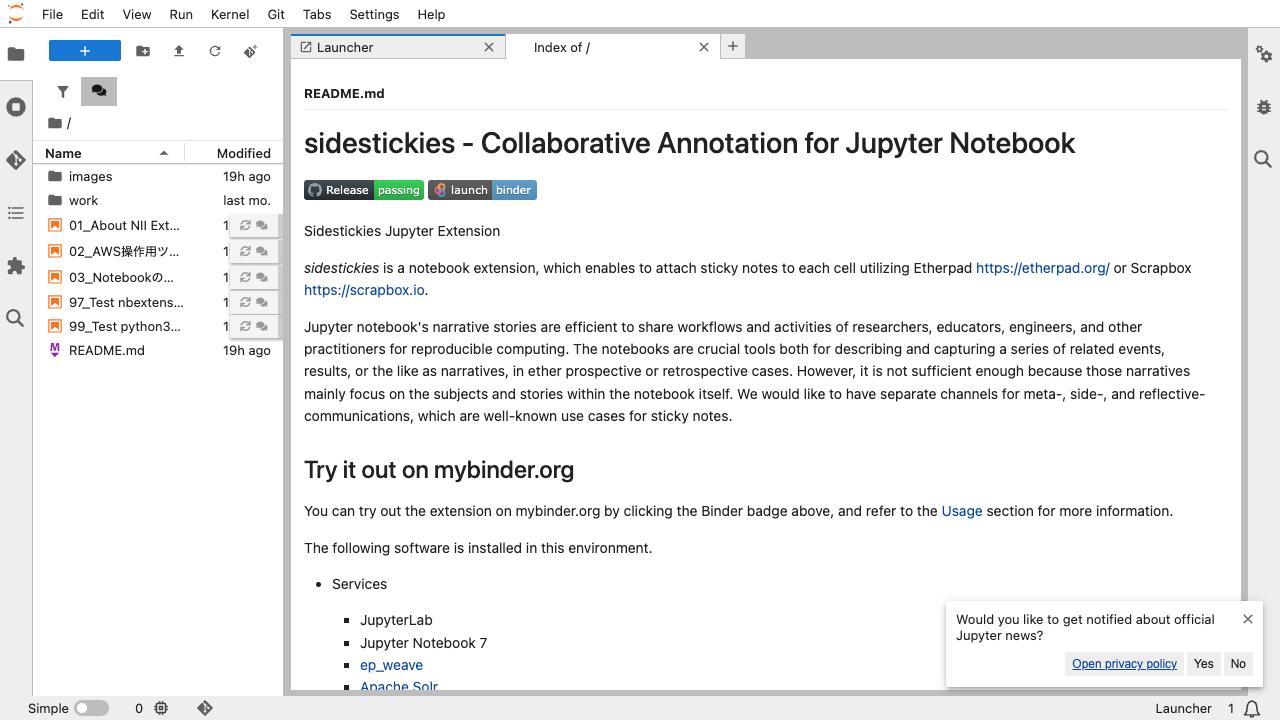

In [226]:
import scripts.sidestickies
importlib.reload(scripts.sidestickies)

test_filename = 'TestNotebook.ipynb'

async def _step(page):
    test_filename_locator = sidestickies.get_file_browser_item_locator(page, test_filename)
    
    if not await test_filename_locator.is_visible():
        print(f"Test notebook '{test_filename}' does not exist. Creating a new one.")
        return
    
    await test_filename_locator.click(button='right')
    await page.locator('//*[@data-command="filebrowser:delete"]').click()

    await page.locator('//*[contains(@class, "jp-Dialog-buttonLabel") and text()="Delete"]').click()

    await expect(test_filename_locator).not_to_be_visible(timeout=transition_timeout)

await run_pw(_step)

## Create a test notebook in the file browser

Start epoch: 1762034443.420842 seconds
Created a new notebook


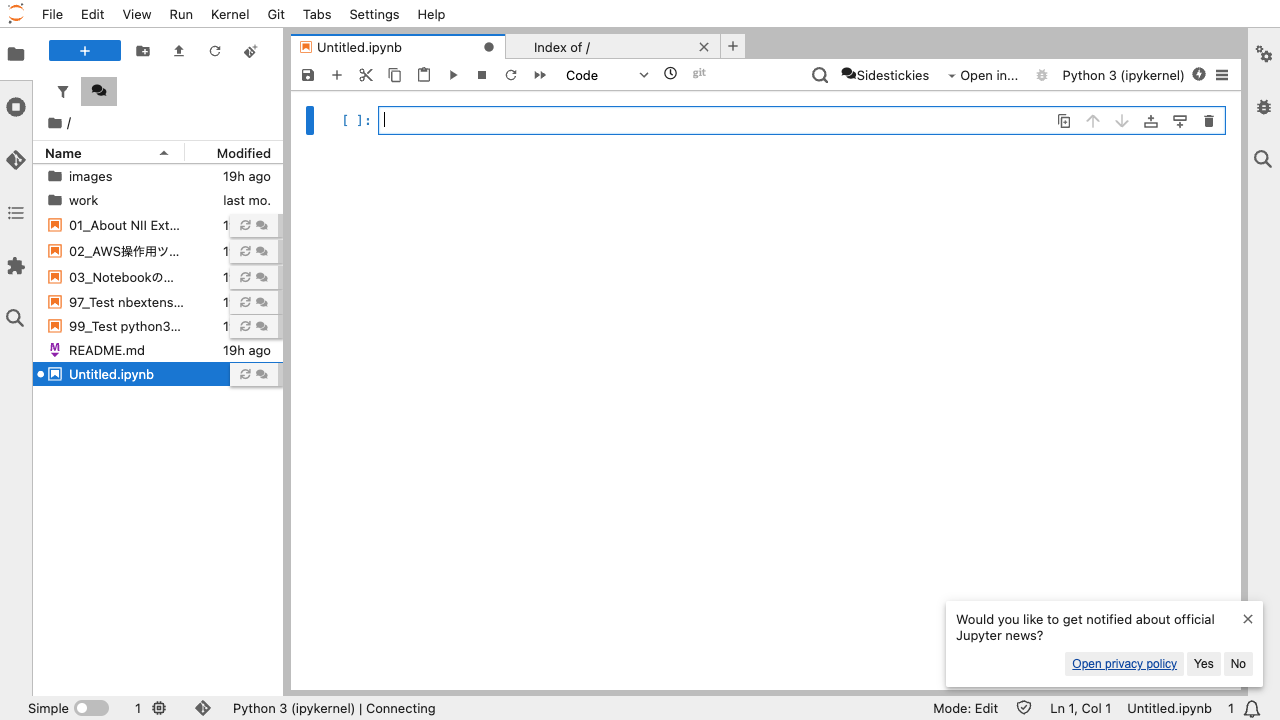

In [227]:
import scripts.sidestickies
importlib.reload(scripts.sidestickies)

created_panel_locator = None

async def _step(page):
    await sidestickies.ensure_launcher_tab_opened(page)

    old_panel_ids = await sidestickies.get_notebook_panel_ids(page)

    # Click on "Python 3" notebook to create a new notebook
    await page.locator('//*[contains(@class, "jp-Launcher-sectionTitle") and text()="Notebook"]/../..').locator('//img[@alt="Python 3 (ipykernel)" and @class="jp-Launcher-kernelIcon"]').click()
    
    # Wait for notebook to open
    await expect(page.locator('//*[contains(@class, "jp-mod-current")]//*[contains(@class, "lm-TabBar-tabLabel") and text() = "Untitled.ipynb"]')).to_be_visible(timeout=transition_timeout)
    
    new_panel_ids = await sidestickies.get_notebook_panel_ids(page)
    created_panel_ids = new_panel_ids - old_panel_ids
    assert len(created_panel_ids) == 1, f"Expected one new notebook panel to be created, old_panel_ids: {old_panel_ids}, new_panel_ids: {new_panel_ids}"
    created_panel_id = created_panel_ids.pop()

    global created_panel_locator
    created_panel_locator = page.locator(f'#{created_panel_id}')

    await expect(sidestickies.get_file_browser_item_locator(page, 'Untitled.ipynb')).to_be_visible(timeout=transition_timeout)

    print("Created a new notebook")

await run_pw(_step)

## Fill the first cell with some content

Start epoch: 1762034444.6571252 seconds


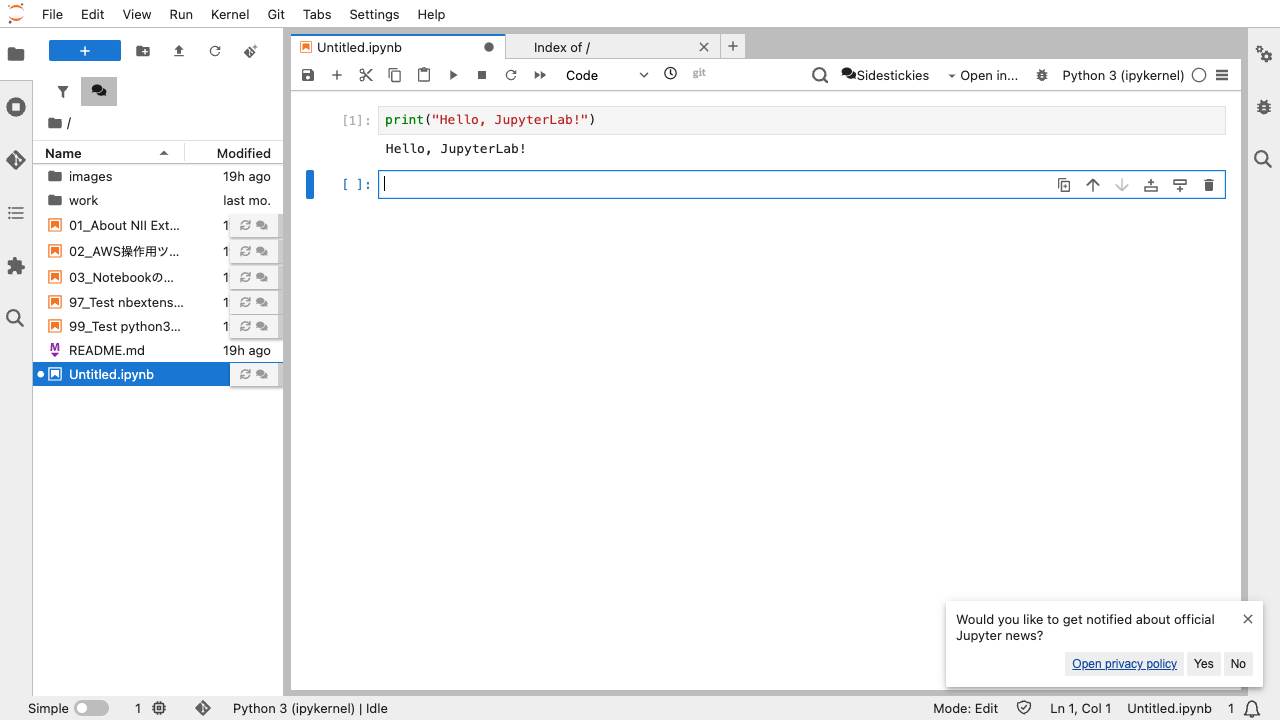

In [228]:
import scripts.sidestickies
importlib.reload(scripts.sidestickies)

async def _step(page):
    cell = created_panel_locator.locator('.jp-Cell-inputArea .cm-content').first
    await sidestickies.input_code_in_cell(page, cell, 'print("Hello, JupyterLab!")')

    await expect(sidestickies.get_current_tab_closer_locator(page).locator('.jp-icon-busy')).to_be_visible(timeout=transition_timeout)

await run_pw(_step)

## Save the notebook

Start epoch: 1762034447.786355 seconds


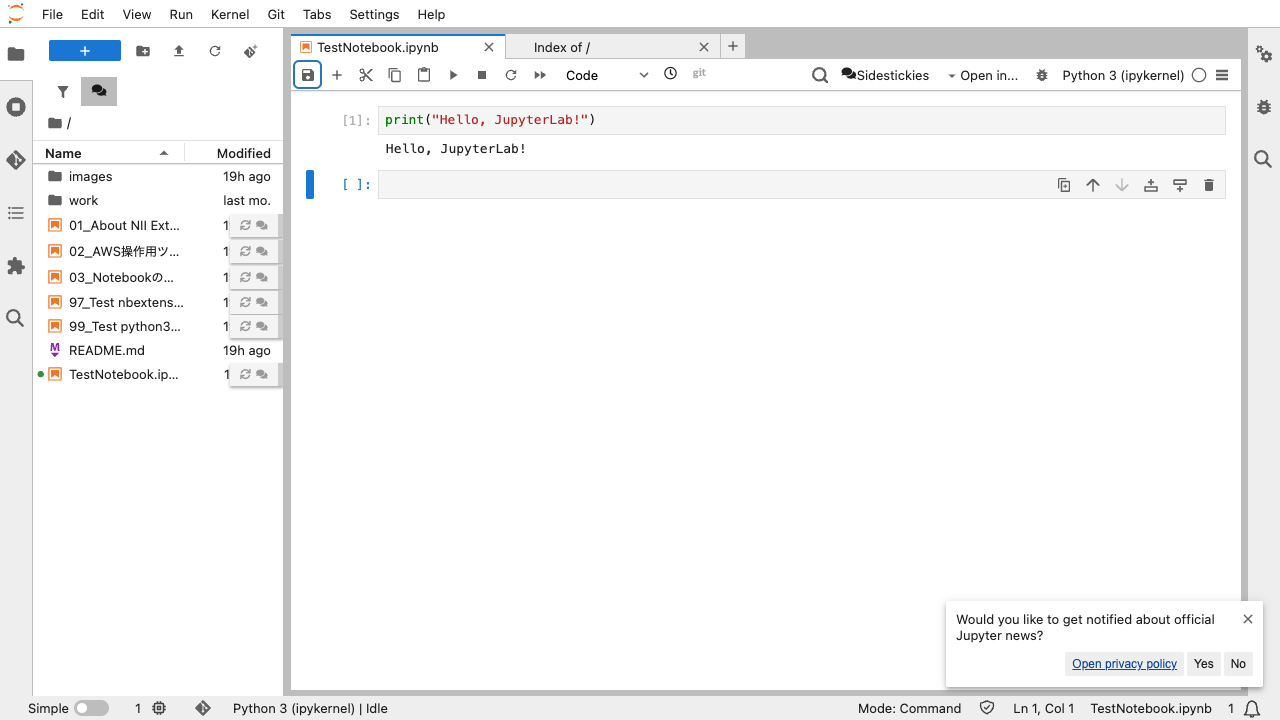

In [229]:
async def _step(page):
    await page.locator('//*[@data-command="docmanager:save"]').click()

    await page.locator('//*[contains(@class, "jp-Dialog-header") and text()="Rename file"]/..//input[@placeholder="File name"]').fill(test_filename)

    await page.locator('//*[contains(@class, "jp-Dialog-buttonLabel") and text()="Rename and Save"]').click()

    await expect(sidestickies.get_file_browser_item_locator(page, test_filename)).to_be_visible(timeout=transition_timeout * 3)

await run_pw(_step)

## Verify sidestickies toggle button exists in notebook toolbar

Start epoch: 1762034461.3573608 seconds
Sidestickies toggle button found in notebook toolbar


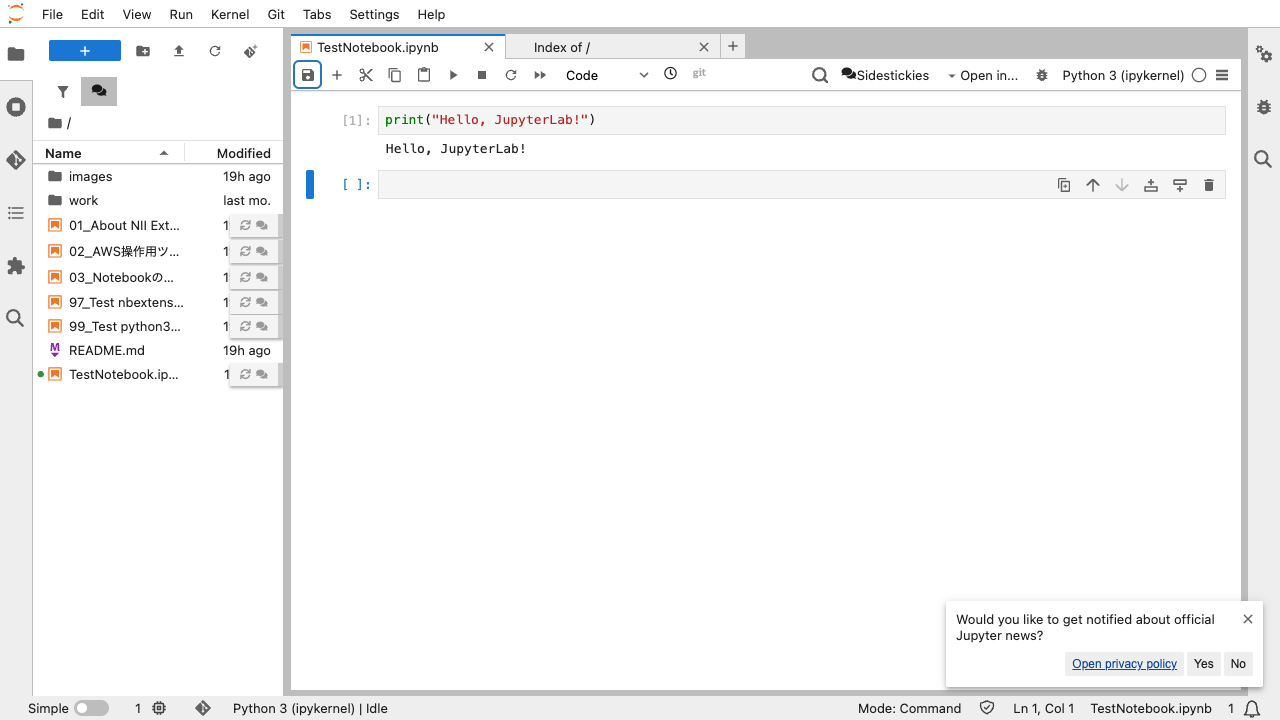

In [230]:
async def _step(page):
    # Look for the sidestickies toggle button in the notebook toolbar
    toggle_button = page.locator('.jp-NotebookPanel .sidestickies-comment-toggle')
    await expect(toggle_button).to_be_visible(timeout=transition_timeout)
    
    print("Sidestickies toggle button found in notebook toolbar")

await run_pw(_step)

## Click the toggle button to enable sidestickies

Start epoch: 1762034461.67733 seconds
Sidestickies enabled in notebook panel


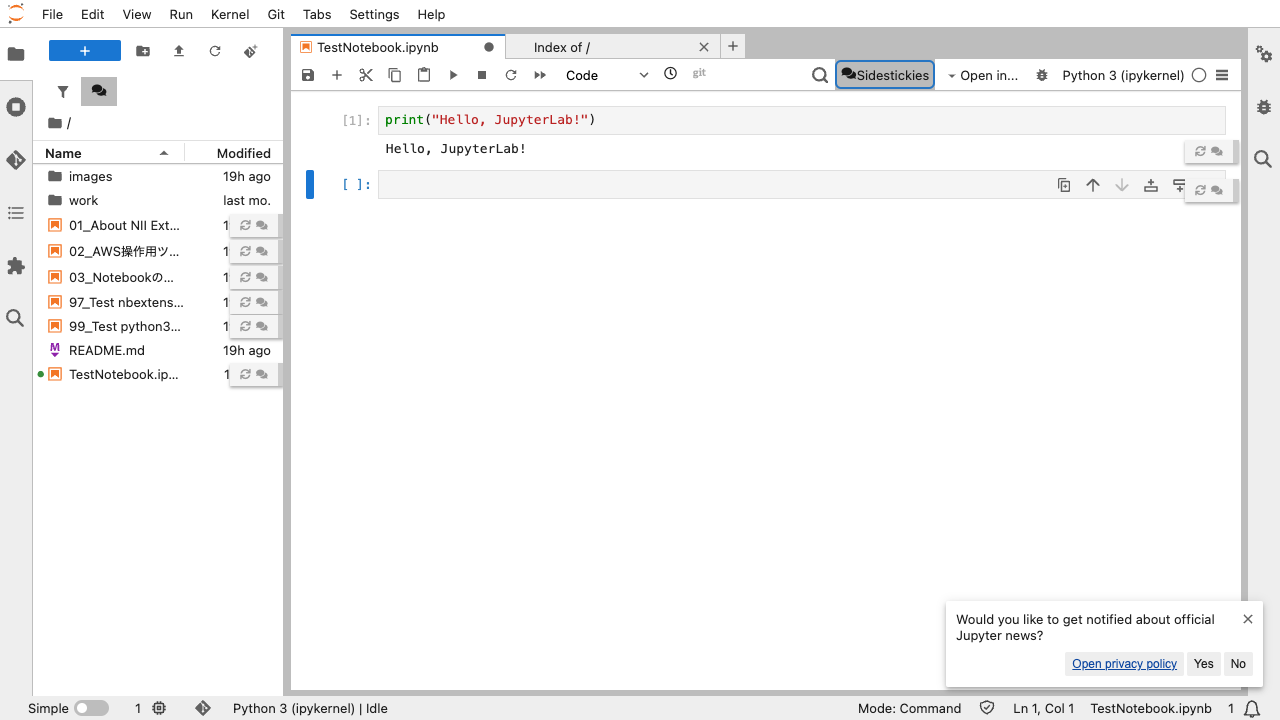

In [231]:
import scripts.sidestickies
importlib.reload(scripts.sidestickies)

async def _step(page):
    toggle_button = sidestickies.get_notebook_sidestickies_button_locator(page)
    await expect(toggle_button).to_be_attached(timeout=transition_timeout)

    attr = await toggle_button.get_attribute('class')
    if 'sidestickies-comment-visible' in attr:
        print("Sidestickies already enabled in notebook toolbar")
        return

    # Click the toggle button
    await toggle_button.click()
    await asyncio.sleep(0.5)
    
    # Verify the button is now in active state
    await expect(toggle_button).to_have_class(re.compile(r'.*sidestickies-comment-visible.*'), timeout=transition_timeout)
    
    print("Sidestickies enabled in notebook panel")

await run_pw(_step)

## Verify that cell tag widgets appear on cells in the notebook

Start epoch: 1762034462.538357 seconds
Notebook tag widgets display correctly on .ipynb files


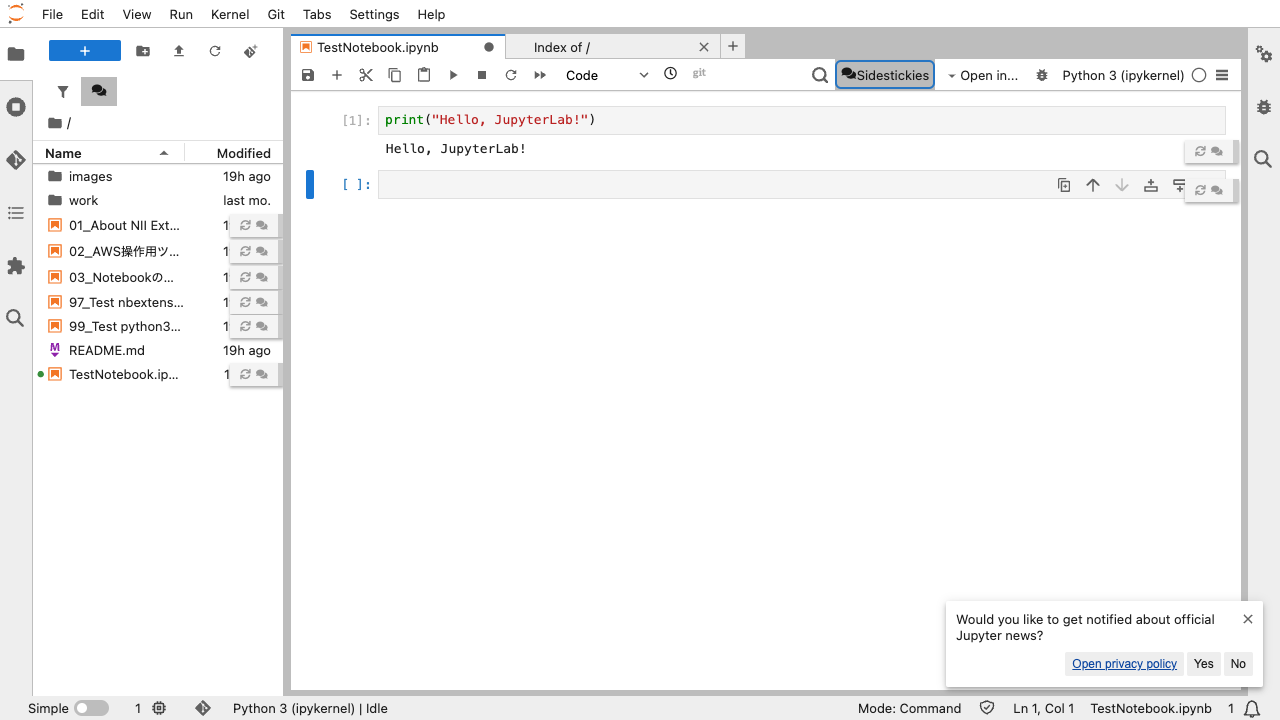

In [232]:
import scripts.sidestickies
importlib.reload(scripts.sidestickies)

async def _step(page):
    note_locator = sidestickies.get_cell_sticky_note_root_locator(page, 0).locator('.nbtags-tag')
    await expect(note_locator).to_be_visible(timeout=transition_timeout)
    
    # Verify the tag has expected structure (refresh icon and comments icon)
    await expect(note_locator.locator('.fa-refresh')).to_be_visible()
    await expect(note_locator.locator('.fa-comments')).to_be_visible()

    print("Notebook tag widgets display correctly on .ipynb files")

await run_pw(_step)

## Open new sticky note for the first cell

Start epoch: 1762034462.856343 seconds


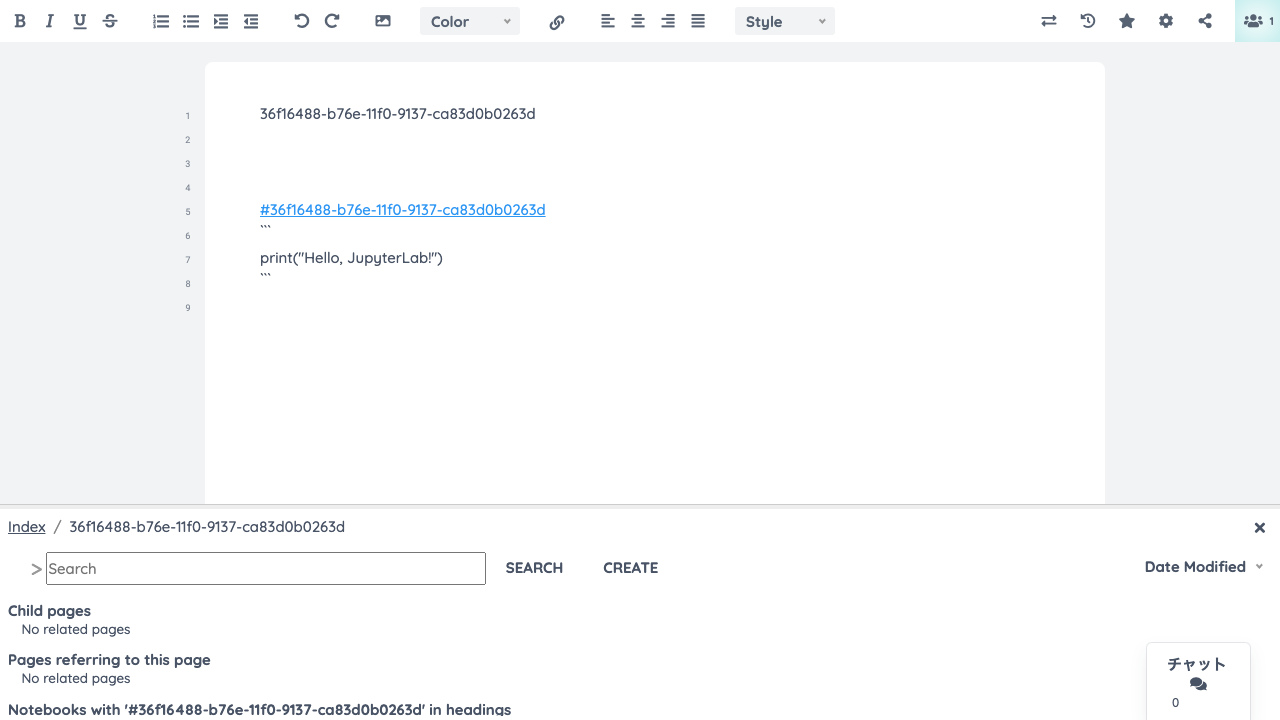

In [233]:
import re

pad_page = None

async def _step(page):
    # Wait for a new window to open
    popup_future = page.wait_for_event('popup')
    await sidestickies.get_cell_sticky_note_root_locator(page, 0).locator('.fa-comments').click()
    popup = await popup_future

    await expect(popup.locator('//iframe[@name="ace_outer"]')).to_be_visible(timeout=transition_timeout)

    global pad_page
    pad_page = popup
    return popup

await run_pw(_step)

## Change the title of the sticky note pad

Start epoch: 1762034464.613703 seconds


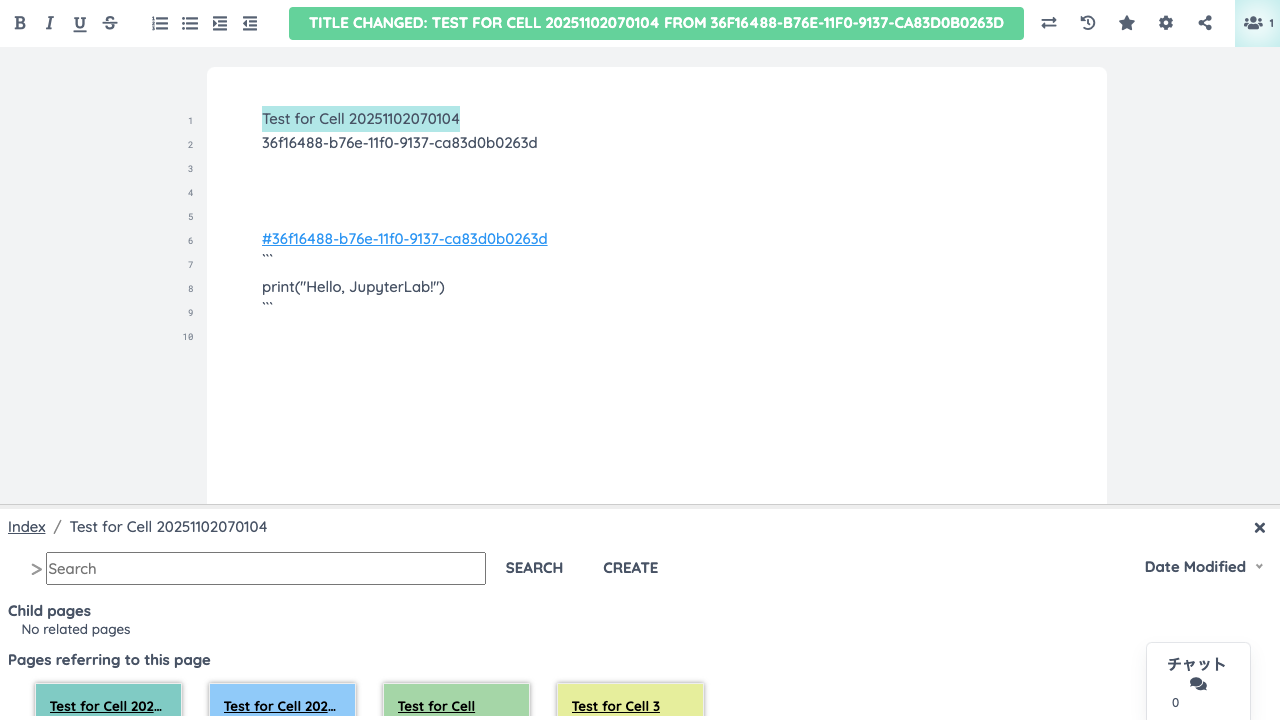

In [234]:
from datetime import datetime
import re

async def extract_ace_inner_docbody(page):
    iframe_locator = page.frame_locator('iframe[name="ace_outer"]').frame_locator('iframe[name="ace_inner"]')
    await expect(iframe_locator.locator('#innerdocbody')).to_be_visible(timeout=transition_timeout)
    return iframe_locator.locator('#innerdocbody')

cell_pad_title = f"Test for Cell {datetime.now().strftime('%Y%m%d%H%M%S')}"

async def _step(page):
    page = pad_page
    inner_docbody = await extract_ace_inner_docbody(page)
    await inner_docbody.focus()

    await inner_docbody.type(cell_pad_title, delay=100)
    await inner_docbody.press("Enter")

    await page.wait_for_load_state('networkidle')
    await asyncio.sleep(1)  # Wait a moment to ensure the title change is processed
    await expect(page).to_have_title(re.compile(f"^{cell_pad_title}"), timeout=transition_timeout)

await run_pw(_step)

## Close the pad window and refresh the sticky note widget

Start epoch: 1762034469.513014 seconds


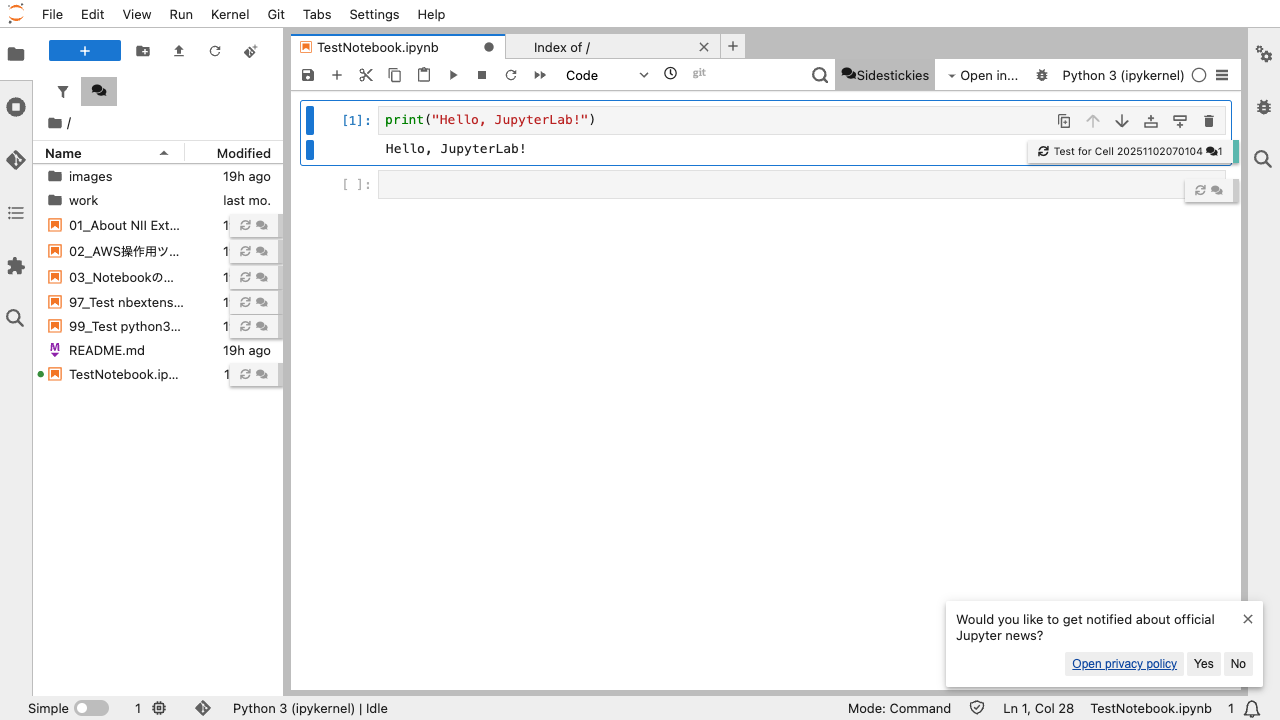

In [235]:
async def _step(page):
    cell = sidestickies.get_cell_sticky_note_root_locator(page, 0)
    await cell.locator('.fa-refresh').click()
    
    await expect(cell.locator('.item_name')).to_have_text(re.compile(cell_pad_title), timeout=transition_timeout)

await close_latest_page()
await run_pw(_step)

## Close the notebook tab

Start epoch: 1762034469.961739 seconds
Closed notebook, returned to file browser


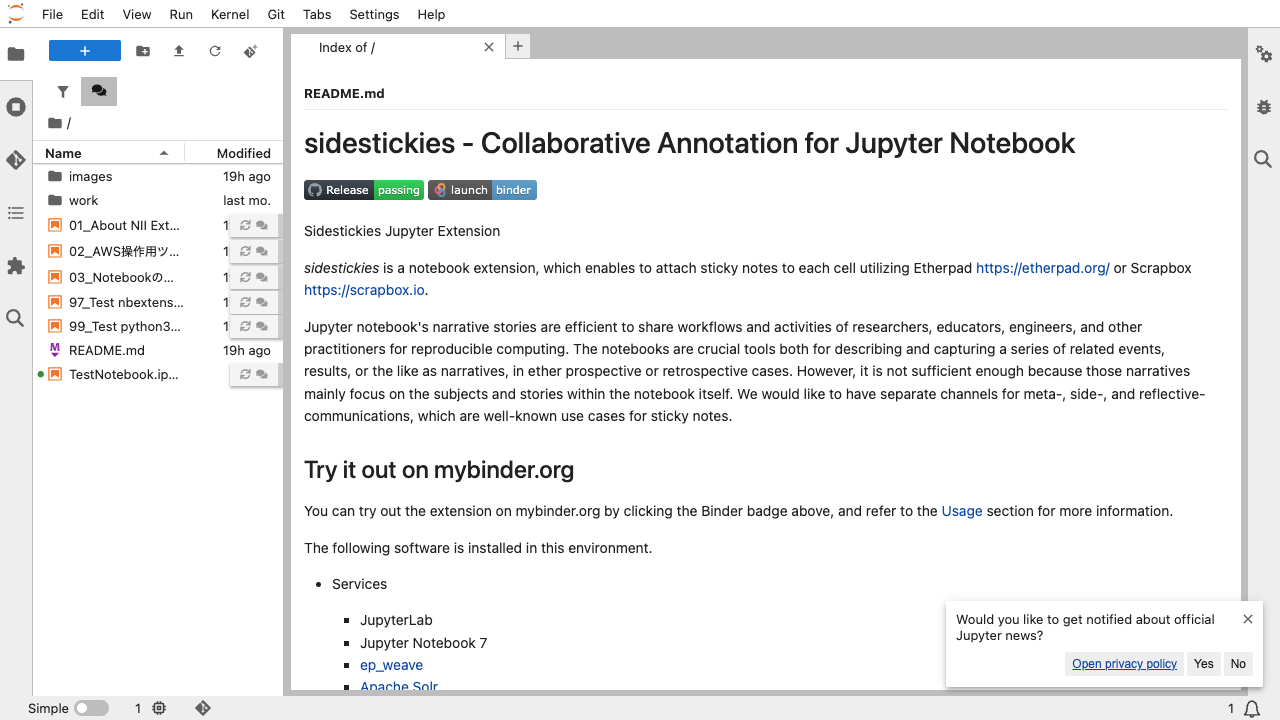

In [236]:
async def _step(page):
    # Close the notebook to return to file browser
    await sidestickies.get_current_tab_closer_locator(page).click()
    
    await page.locator('.jp-Dialog-buttonLabel', has_text='Save').click()

    print("Closed notebook, returned to file browser")

await run_pw(_step)

## Verify sidestickies toggle button exists in file browser toolbar

Start epoch: 1762034470.354391 seconds
Sidestickies toggle button found in file browser


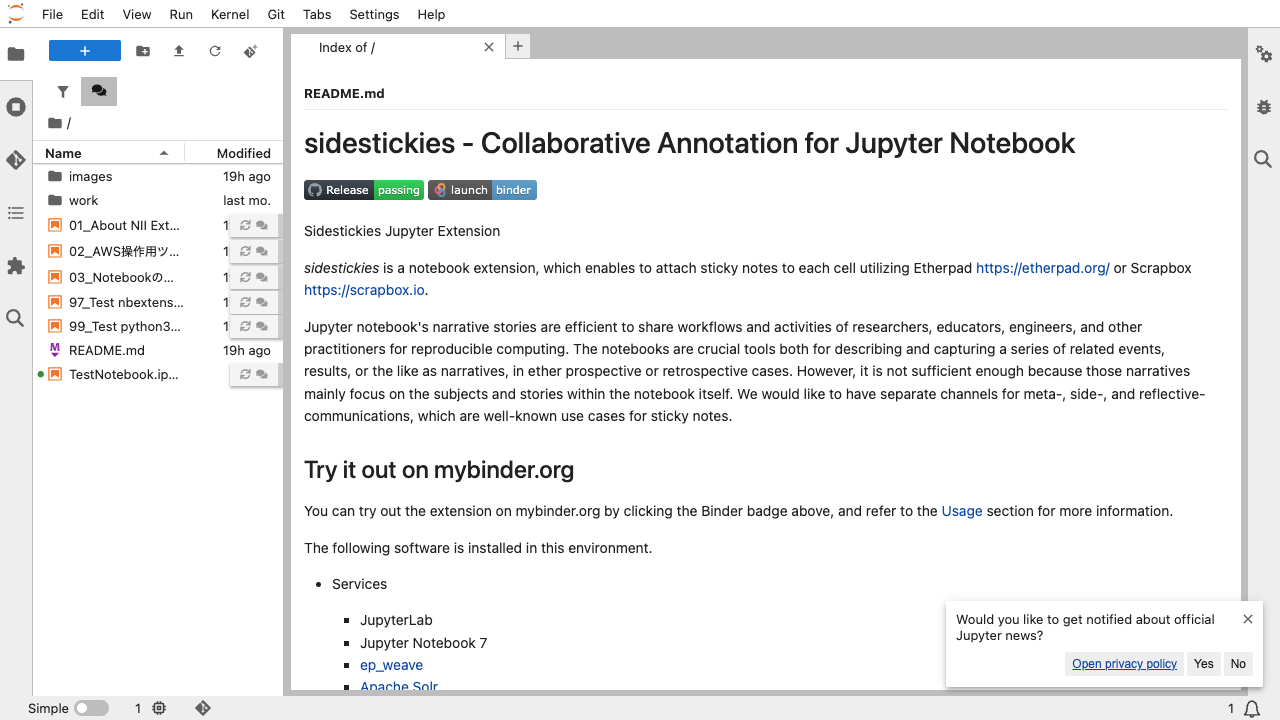

In [237]:
async def _step(page):
    # Look for the sidestickies toggle button in the file browser toolbar
    toggle_button = page.locator('.jp-FileBrowser .sidestickies-comment-toggle')
    await expect(toggle_button).to_be_visible(timeout=transition_timeout)
    
    print("Sidestickies toggle button found in file browser")

await run_pw(_step)

## Click the toggle button to enable sidestickies

Start epoch: 1762034470.636876 seconds
Sidestickies already enabled in file browser


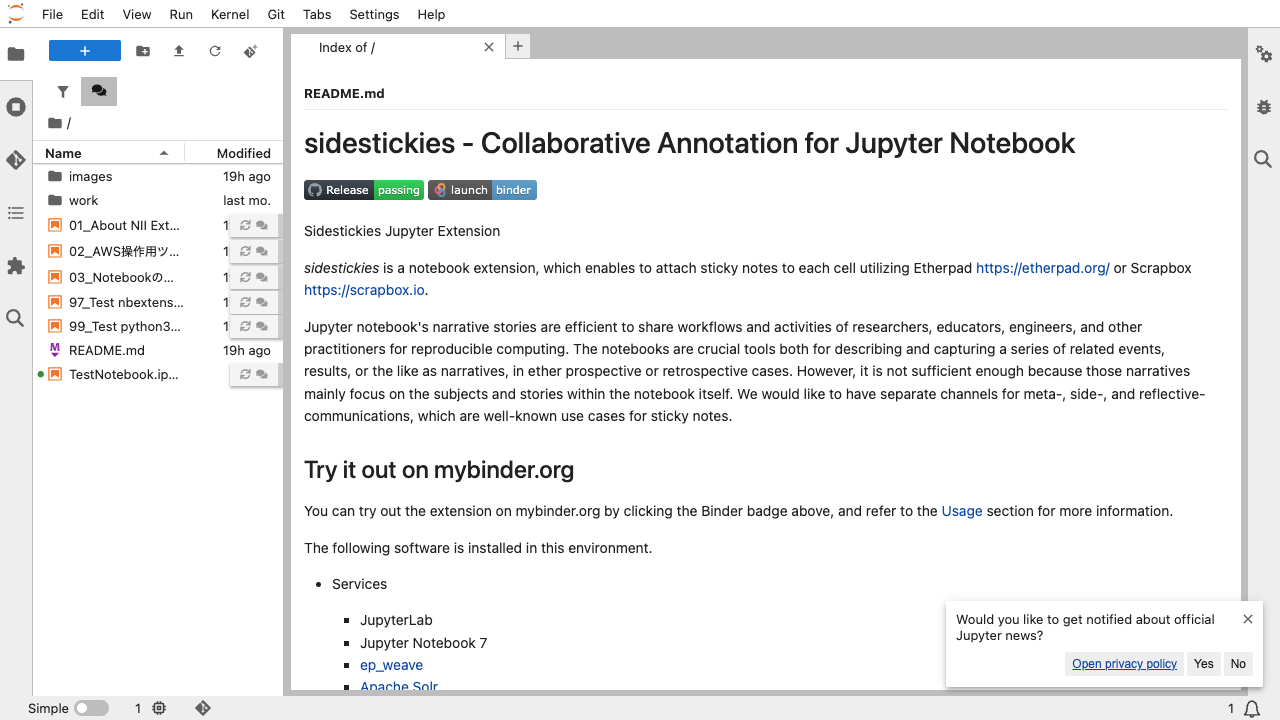

In [238]:
import scripts.sidestickies
importlib.reload(scripts.sidestickies)

async def _step(page):
    toggle_button = sidestickies.get_file_browser_sidestickies_button_locator(page)
    await expect(toggle_button).to_be_attached(timeout=transition_timeout)

    attr = await toggle_button.get_attribute('class')
    if 'sidestickies-comment-visible' in attr:
        print("Sidestickies already enabled in file browser")
        return

    # Click the toggle button
    await toggle_button.click()
    await asyncio.sleep(0.5)
    
    # Verify the button is now in active state
    await expect(toggle_button).to_have_class(re.compile(r'.*sidestickies-comment-visible.*'), timeout=transition_timeout)
    
    print("Sidestickies enabled in file browser")

await run_pw(_step)

## Verify that notebook tag widgets appear on .ipynb files

Start epoch: 1762034470.924172 seconds
Notebook tag widgets display correctly on .ipynb files


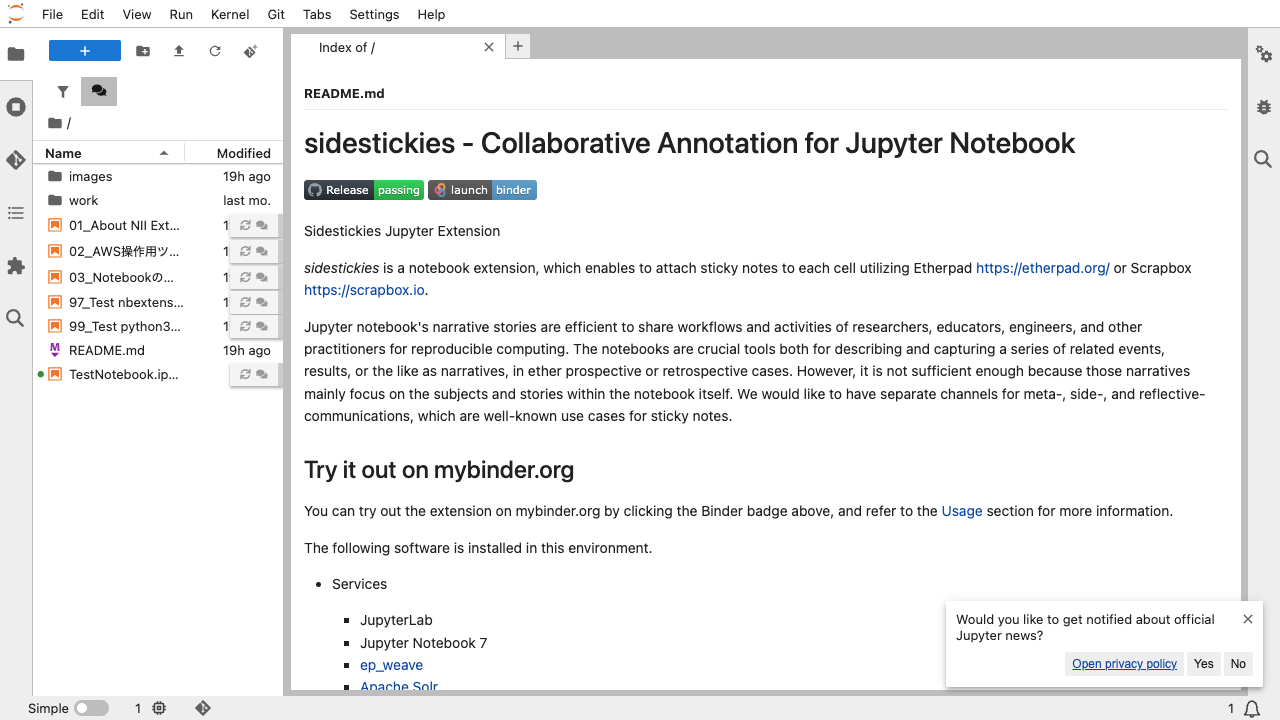

In [239]:
import scripts.sidestickies
importlib.reload(scripts.sidestickies)

async def _step(page):
    note_locator = sidestickies.get_file_sticky_note_root_locator(page, test_filename).locator('.nbtags-tag')
    await expect(note_locator).to_be_visible(timeout=transition_timeout)
    
    # Verify the tag has expected structure (refresh icon and comments icon)
    await expect(note_locator.locator('.fa-refresh')).to_be_visible()
    await expect(note_locator.locator('.fa-comments')).to_be_visible()

    print("Notebook tag widgets display correctly on .ipynb files")

await run_pw(_step)

## Open new sticky note for the notebook file

Start epoch: 1762034471.247039 seconds


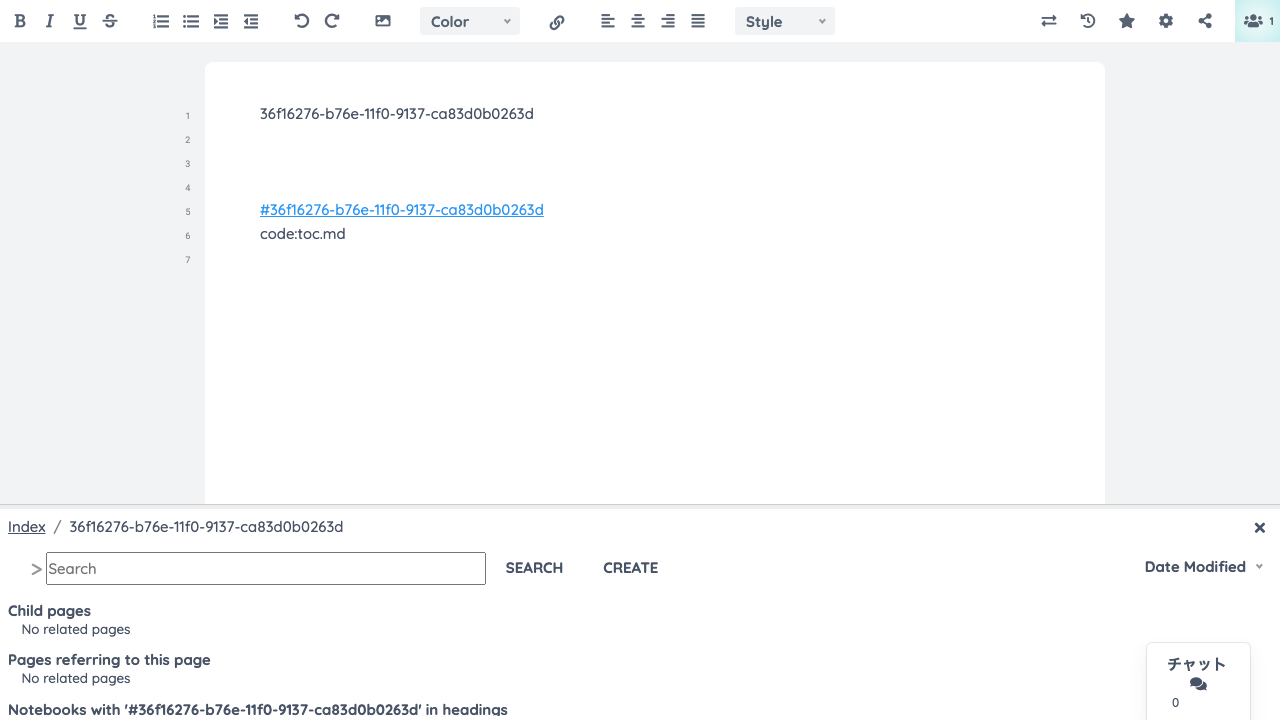

In [240]:
import re

pad_page = None

async def _step(page):
    # Wait for a new window to open
    popup_future = page.wait_for_event('popup')
    await sidestickies.get_file_sticky_note_root_locator(page, test_filename).locator('.fa-comments').click()
    popup = await popup_future

    await expect(popup.locator('//iframe[@name="ace_outer"]')).to_be_visible(timeout=transition_timeout)

    global pad_page
    pad_page = popup
    return popup

await run_pw(_step)

## Change the title of the sticky note pad

Start epoch: 1762034472.1560519 seconds


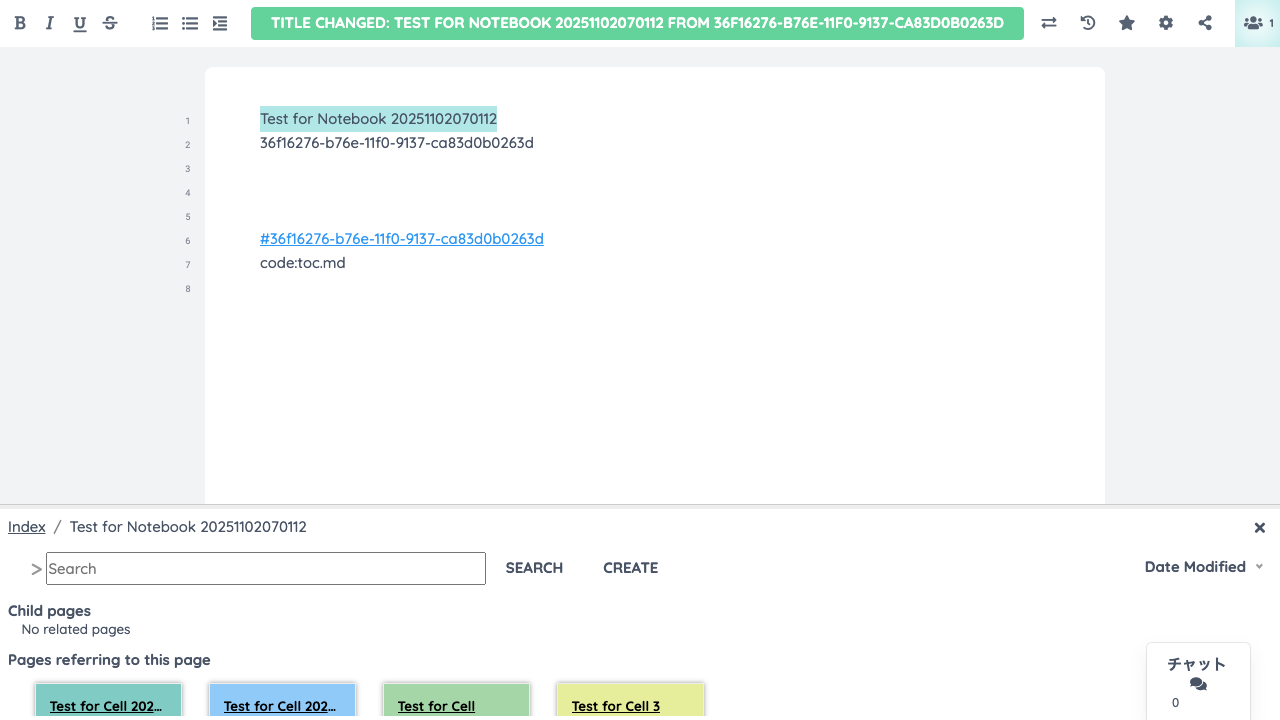

In [241]:
from datetime import datetime
import re

async def extract_ace_inner_docbody(page):
    iframe_locator = page.frame_locator('iframe[name="ace_outer"]').frame_locator('iframe[name="ace_inner"]')
    await expect(iframe_locator.locator('#innerdocbody')).to_be_visible(timeout=transition_timeout)
    return iframe_locator.locator('#innerdocbody')

notebook_pad_title = f"Test for Notebook {datetime.now().strftime('%Y%m%d%H%M%S')}"

async def _step(page):
    page = pad_page
    inner_docbody = await extract_ace_inner_docbody(page)
    await inner_docbody.focus()

    await inner_docbody.type(notebook_pad_title, delay=100)
    await inner_docbody.press("Enter")

    await page.wait_for_load_state('networkidle')
    await asyncio.sleep(1)  # Wait a moment to ensure the title change is processed
    await expect(page).to_have_title(re.compile(f"^{notebook_pad_title}"), timeout=transition_timeout)

await run_pw(_step)

## Close the pad window and refresh the sticky note widget

Start epoch: 1762034477.4442408 seconds


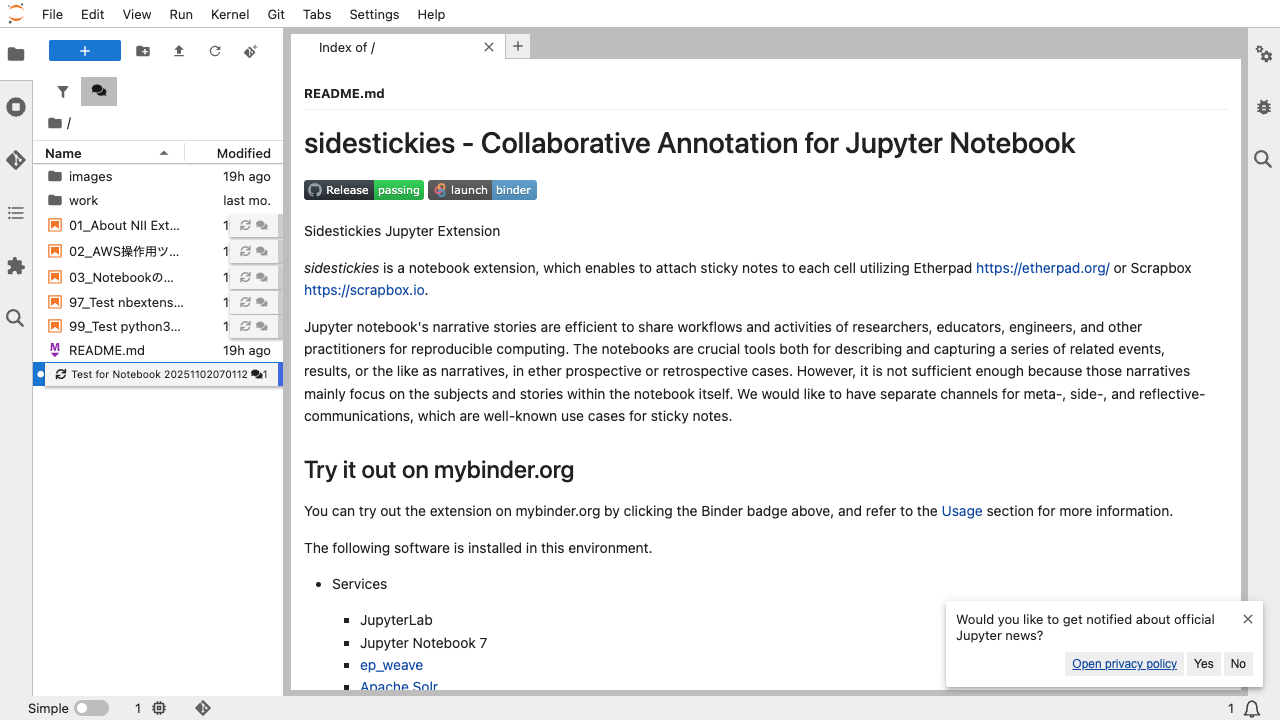

In [242]:
async def _step(page):
    cell = sidestickies.get_file_sticky_note_root_locator(page, test_filename)
    await cell.locator('.fa-refresh').click()

    await expect(cell.locator('.item_name')).to_have_text(re.compile(notebook_pad_title), timeout=transition_timeout)

await close_latest_page()
await run_pw(_step)

## Toggle sidestickies off and verify tags disappear

Start epoch: 1762034478.1839008 seconds
Tag count after disabling: 0
Sidestickies successfully disabled in file browser


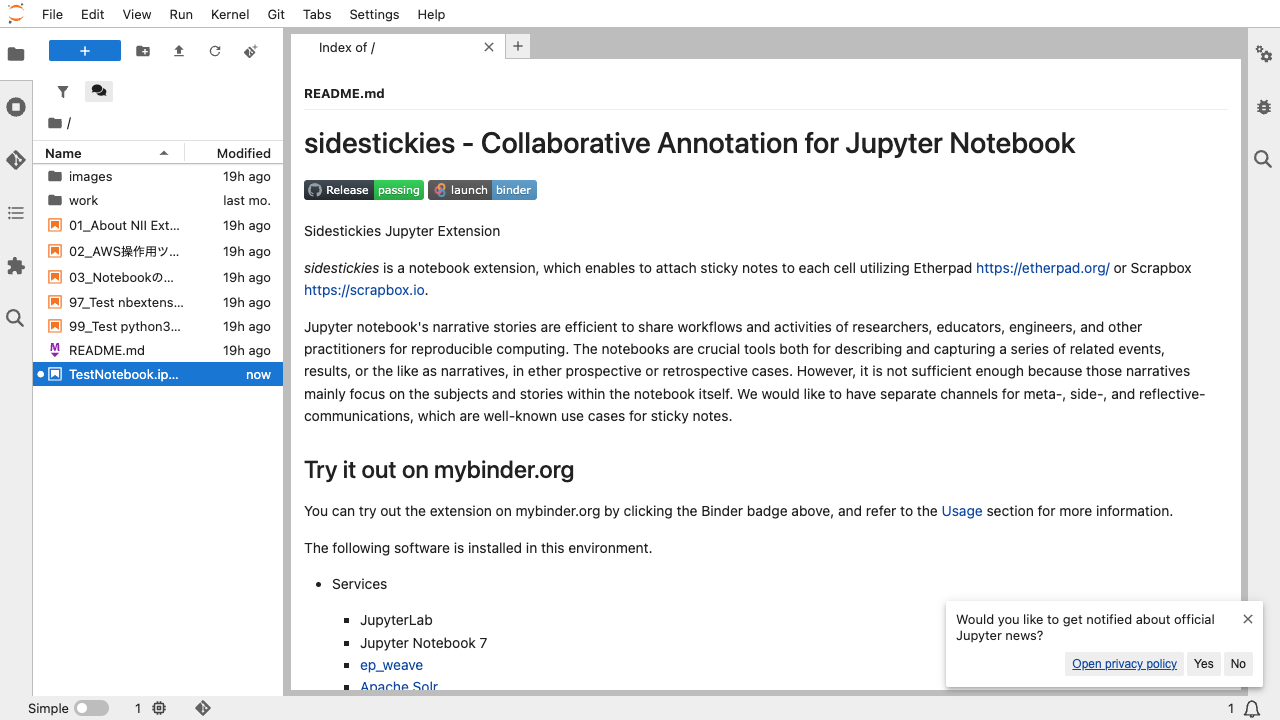

In [243]:
async def _step(page):
    toggle_button = page.locator('.jp-FileBrowser .sidestickies-comment-toggle')

    # Click the toggle button again to disable
    await toggle_button.click()
    await asyncio.sleep(0.5)
    
    # Verify the active state indicator is no longer visible
    await expect(toggle_button.locator('.sidestickies-comment-visible')).not_to_be_visible()
    
    # Verify that tag widgets are no longer visible
    tag_elements = page.locator('li.jp-DirListing-item .nbtags-tag')
    tag_count = await tag_elements.count()
    
    print(f"Tag count after disabling: {tag_count}")
    assert tag_count == 0, "Notebook tag widgets should not be visible when sidestickies is disabled"
    
    print("Sidestickies successfully disabled in file browser")

await run_pw(_step)

## Clean up

In [244]:
await finish_pw_context()

Video: /var/folders/m0/myy2ys0s3cl_73__2gw8fw140000gn/T/tmph43o09lc/video-1.webm
HAR: /var/folders/m0/myy2ys0s3cl_73__2gw8fw140000gn/T/tmph43o09lc/har.zip


スクリーンキャプチャ動画の取得に失敗しました。
Traceback (most recent call last):
  File "/Users/yazawa/workspace/nii-cloud/sidestickies/ui-tests/e2e-notebook/notebooks/scripts/playwright.py", line 208, in _finish_pw_context
    shutil.copyfile(video_path, dest_video_path)
  File "/Users/yazawa/.pyenv/versions/3.11.5/lib/python3.11/shutil.py", line 256, in copyfile
    with open(src, 'rb') as fsrc:
         ^^^^^^^^^^^^^^^
FileNotFoundError: [Errno 2] No such file or directory: '/var/folders/m0/myy2ys0s3cl_73__2gw8fw140000gn/T/tmp0wtov2bq/videos/3db69d9df6269f13b495a5d6ee8152e0.webm'


In [245]:
!rm -fr {work_dir}